## Concise: 1: Start and mesh
Author: yanjun zhang, Source from book "Abali - 2017 - Computational Reality" P119

DOLFINx version: 0.8.0
Simulation environment setup complete.
1: Total braking tims is  49.89 s
2: Total numb steps is  608
The file 'm-3-5.msh' exists, start creat now:
Info    : Reading 'm-3-5.msh'...
Info    : 168 entities
Info    : 57455 nodes
Info    : 271817 elements
Info    : Done reading 'm-3-5.msh'                                         

1: Progress: 0.1%. Use time: 11 s. Start: 2024-11-03 15:00:48.                  
t and T have been successfully saved as Result_T-s-1-d-224-m-3-5-c-1-e-271817.csv


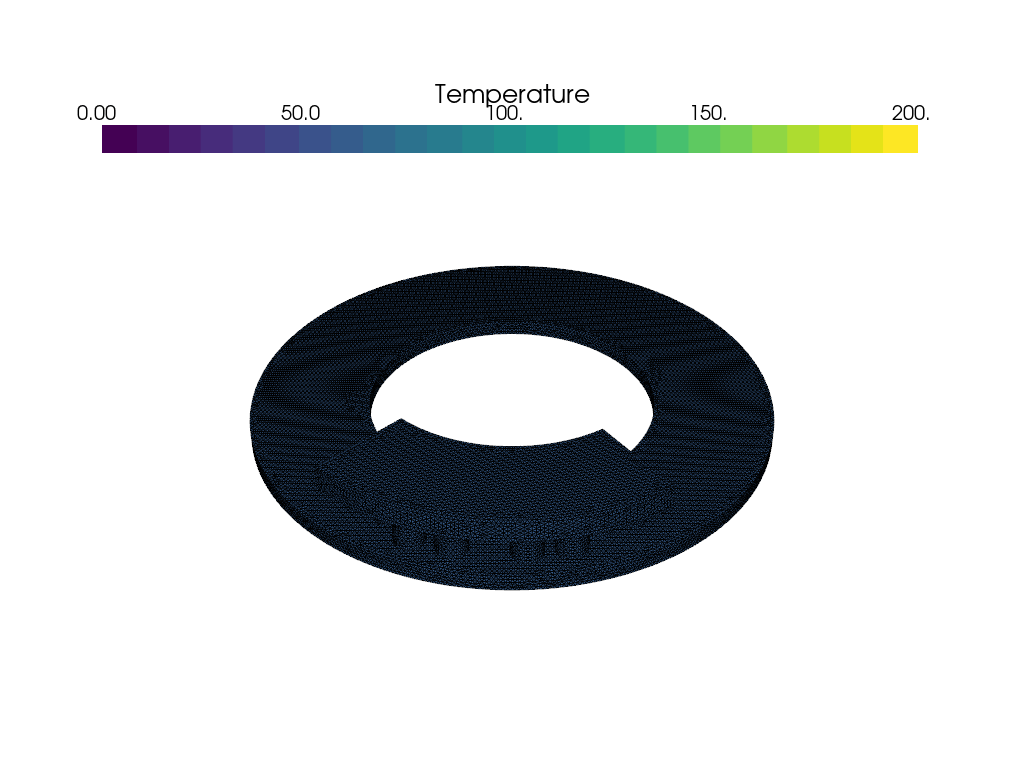

In [1]:
from disc_f import *

# mesh-size, contact area coefficient
mesh_min, mesh_max = 3, 5
c_contact          = 1
# Each time step rotation angular, and acc during lag, 1 is full acc, 0 is no acc.
angular_r          = 224
v_vehicle, c_acc   = 160, 1
z1,z2,z3,z_all     = 20,33,30,8
pad_v_tag          = 32
# calling local functions to get all parameters
(dt, P, g, num_steps, h, radiation, v_angular, Ti, Tm, S_rub_circle, t, rho, c, k, t_brake, 
S_total,) = vehicle_initial (angular_r, v_vehicle, c_contact, c_acc)
print("1: Total braking tims is ", round(sum(dt), 2), "s")
print("2: Total numb steps is ", num_steps)

## here use lots of abbreviation, details are in disc_f
domain, cell_markers, facet_markers, mesh_name, mesh_name1, mesh_name2 \
                       = mesh_brake_all(mesh_min,mesh_max,pad_v_tag)
V, T_init, u_n         = initial_u_n(domain, Ti)
fdim, bc, mesh_brake, all_e,xdmf, x_co, y_co, ds, b_con \
                       = mesh_setup(domain, V,mesh_name1,num_steps, \
                         angular_r, mesh_name2, c_contact,z_all,Tm, S_rub_circle)
# Initialize
problem,u,v,f,n_vector = variation_initial(V, T_init,domain, rho, c, b_con,\
                          radiation, h, k, xdmf,dt,ds,u_n, Tm,g,bc);
n,converged = solver_setup_solve(problem,u)

## Visualization of time dependent problem using pyvista
gif_name    = "T-s-{}-d-{}-{}-c-{}-e-{}.gif".format(num_steps, angular_r, mesh_name2, c_contact, all_e)
plotter, sargs, renderer, warped, viridis, grid = plot_gif(V,u,gif_name)
##solve
#num_steps= int(num_steps/10/6)
num_steps= int(1)

T_array     = solve_heat(Ti, u, num_steps, dt, x_co, y_co, angular_r,t_brake, \
                     domain,S_rub_circle,fdim, rho, c, v, radiation, k, h, \
                     f,Tm,u_n,g, ds, xdmf, b_con,bc,plotter,warped)

csv_name    = "Result_T-s-{}-d-{}-{}-c-{}-e-{}.csv".format(num_steps, angular_r, mesh_name2, c_contact, all_e  )
# got the Temperature data
save_t_T(csv_name, T_array)

from IPython.display import display, Image
display(Image(gif_name))

# 2: New brake pad points, add boundary for rubbing elements

Info    : Reading 'm-3-5.msh'...
Info    : 168 entities
Info    : 57455 nodes
Info    : 271817 elements
Volume:, Tag:31                                                            
Volume:, Tag:32
Info    : Done reading 'm-3-5.msh'
Info    : Meshing 1D...
Info    : Done meshing 1D (Wall 5.0844e-05s, CPU 7.3e-05s)
Info    : Meshing 2D...
Info    : Done meshing 2D (Wall 9.1072e-05s, CPU 4.5e-05s)
Info    : Meshing 3D...
Info    : Done meshing 3D (Wall 0.812881s, CPU 0.738797s)
Info    : Optimizing mesh...
Info    : Done optimizing mesh (Wall 0.00506318s, CPU 0.000977s)
Info    : 57455 nodes 271865 elements
Info    : Writing 'new_pad.msh'...
Info    : Done writing 'new_pad.msh'
Info    : Reading 'm-3-5.msh'...
Info    : 168 entities
Info    : 57455 nodes
Info    : 271817 elements
Info    : Done reading 'm-3-5.msh'                                         
Info    : Reading 'new_pad.msh'...
Info    : 168 entities
Info    : 17025 nodes
Info    : 78227 elements
Info    : Done reading 'new_pad.

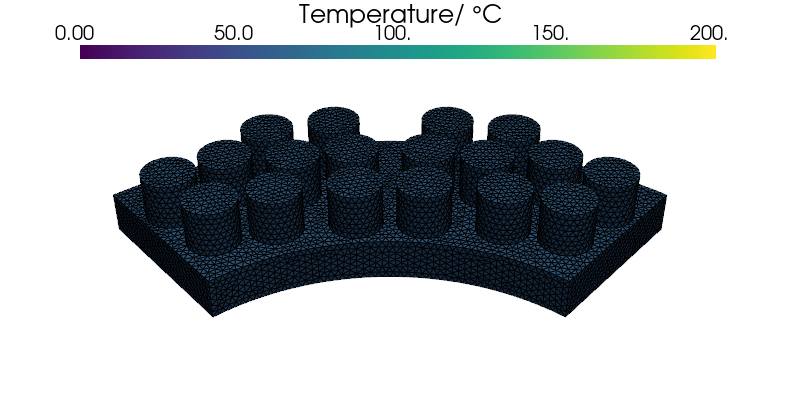

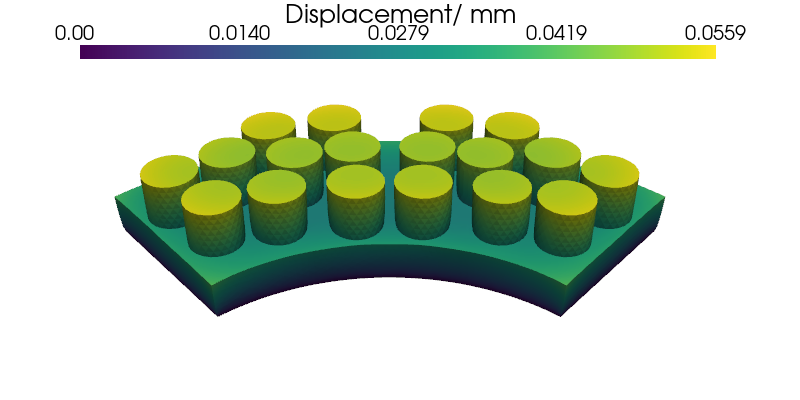

In [2]:
## plot the temperature
mesh_n_pad = mesh_del_disc(mesh_name1, "new_pad.msh")
T_new_p, pad_node_coordinates  = T_pad_transfer1( mesh_name1, mesh_n_pad, u_n, mesh_brake, pad_v_tag )
domain_pad, cell_mark_pad, facet_mark_pad = gmshio.read_from_msh( mesh_n_pad , MPI.COMM_WORLD, 0, gdim=3 )
plot_T_pad( domain_pad, T_new_p).show()

# defin the pad domain
VT      = fem.functionspace(domain_pad, ("CG", 1))         #define the finite element function space
Delta_T = fem.Function(VT, name ="Temperature_variation")  # T_ is the test function, like v

#for i in range(len(T_new_p)):
#    Delta_T.vector.array[i] = T_new_p[i]

#######try to make domain only for brake pad.
E    = fem.Constant(domain_pad, 50e3)             # Elastic module
nu   = fem.Constant(domain_pad, 0.2)              # Poission ratio
gdim = domain_pad.geometry.dim

mu    = E / 2 / (1 + nu)                          # Shear modulus
lmbda = E * nu / (1 + nu) / (1 - 2 * nu)          # Lame parameters
alpha = fem.Constant(domain_pad, 1e-5)            # Thermal expansion coefficient
f1    = fem.Constant(domain_pad, (0.0, 0.0, 0.0)) # O for external force

def eps(v):                                       # epsilon, strain, the deforamtion, dy/y 
    return ufl.sym(ufl.grad(v))
def sigma(v, Delta_T):                            # sigmathis is sigma
    return (lmbda * ufl.tr(eps(v)) - alpha * (3 * lmbda + 2 * mu) * Delta_T 
    ) * ufl.Identity(gdim)  + 2.0 * mu * eps(v)   # here braces is important, can not be in above line

Vu = fem.functionspace(domain_pad, ("CG", 1, (gdim,))) 
du = ufl.TrialFunction(Vu)
u_ = ufl.TestFunction(Vu)

Wint = ufl.inner(sigma(du, Delta_T), eps(u_)) * ufl.dx  # here du is unkown
aM   = ufl.lhs(Wint)                                    # Wint is long and lhs can help to distinguish unkown and know.
LM   = ufl.rhs(Wint) + ufl.inner(f1, u_) * ufl.dx       # knows parameters are in lhs

def up_side(x):
    return np.isclose(x[2], (z1+z2+z3))

up_dofs_u = fem.locate_dofs_geometrical(Vu, up_side)   # lateral sides of domain
bcu       = [fem.dirichletbc(np.zeros((gdim,)), up_dofs_u, Vu)]  # displacement Vu is fixed in lateral sides

u_d     = fem.Function(Vu, name="Displacement")
problem = fem.petsc.LinearProblem(aM, LM, u=u_d, bcs=bcu)
problem.solve()

scale_factor = 100
plot_s_pad = plot_S_pad(Vu,u_d,scale_factor )
plot_s_pad.show()


## Penalty method

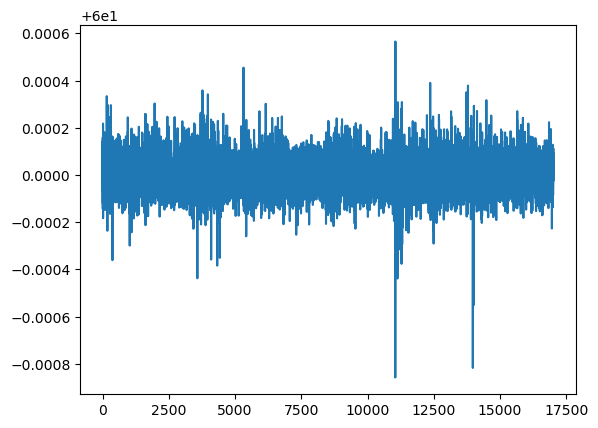

In [4]:
plt.plot(T_new_p)

In [ ]:
def bottom_contact_nodes(x):
    return np.isclose(x[2], z1)
contact_dofs = fem.locate_dofs_geometrical(Vu, bottom_contact_nodes)
penalty_param = 400
# Create a function to store penalty forces in the same function space as displacement
penalty_forces = fem.Function(Vu)
def update_penalty_force(u_d, penalty_forces, z1, penalty_param):
    u_vals = u_d.x.array.reshape(-1, gdim)
    penalty_forces_vals = penalty_forces.x.array.reshape(-1, gdim)
    # Apply penalty force for nodes below z1
    for dof in contact_dofs:
        if u_vals[dof][2] < 0:  ## here should <0 because contact surface is minus once expend with no constrain.
            penalty_forces_vals[dof][2] = -penalty_param * ( u_vals[dof][2]) # if here is not minus, rubing element grew up
        else:
            penalty_forces_vals[dof][2] = 0.0  # No penalty force if above z1
    penalty_forces.x.array[:] = penalty_forces_vals.ravel()

u_d = fem.Function(Vu, name="Displacement")
problem = fem.petsc.LinearProblem(aM, LM, u=u_d, bcs=bcu)
problem.solve()


update_penalty_force(u_d, penalty_forces, z1, penalty_param)
u_d = fem.Function(Vu, name="Displacement")
LM_penalized = LM + ufl.inner(penalty_forces, u_) * ufl.dx
problem = fem.petsc.LinearProblem(aM, LM_penalized, u=u_d, bcs=bcu)
problem.solve()

scale_factor = 1
plot_s_pad = plot_S_pad(Vu, u_d, scale_factor)
plot_s_pad.show()


## Get contact zone nodes

In [ ]:
x_co_zone   = 0.002
deformed_co, new_c = get_new_contact_nodes(x_co_zone, domain_pad, u_d,  Vu, z1, x_co, y_co )
x_co_new, y_co_new, r_rub_new, S_total_new,S_rub_circle_new = get_r_xco_yco (deformed_co, new_c )
fraction_c = []
fraction_c.append( (S_total_new)/(200) )
print('Total contact surface is: ', round(S_total_new, 2), " mm")
print("Contact friction is ", fraction_c)

In [ ]:
vtk = io.VTKFile(domain_pad.comm, "pad_deformation", "w")
vtk.write_function(u_d)
vtk.close()

## 1: Visualizing the displacement profile in the z-direction
plt.plot(u_d.x.array[2::3])
plt.title("Displacement in z-direction")
plt.xlabel("Node Index")
plt.ylabel("Displacement (z-direction)")
plt.grid()
plt.show()

Identify contact areas and plot them
contact_nodes = np.where(u_d.x.array[2::3] >= z1)[0]  # Nodes in contact with the surface at z1
contact_coordinates = pad_node_coordinates[contact_nodes]  # Get the coordinates of contact nodes

Plotting contact nodes
plt.scatter(contact_coordinates[:, 0], contact_coordinates[:, 1], label="Contact Nodes", c='red', s=10)
plt.title("Contact Area on Brake Pad")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.grid()
plt.legend()
plt.show()

## 2: Cut the nodes below the z1, but this method is not perfect since only x[2]=z1 in the begin are cuted.

def bottom_contact_nodes(x):
    return np.isclose(x[2], z1)
contact_dofs = fem.locate_dofs_geometrical(Vu, bottom_contact_nodes)
u_d = fem.Function(Vu, name="Displacement")
problem = fem.petsc.LinearProblem(aM, LM, u=u_d, bcs=bcu)
problem.solve()
u_vals = u_d.x.array.reshape(-1, gdim)   # Get displacement values
for dof in contact_dofs:
    if u_vals[dof][2] < z1:
        u_vals[dof][2] = 0  # Set minimum z value to z1
u_d.x.array[:] = u_vals.ravel()
scale_factor = 1
plot_s_pad = plot_S_pad(Vu, u_d, scale_factor)
plot_s_pad.show()

## 3: Relationship between penalty stiffness and the maximum penatration.

n = 4
deform_max=[]
for i in range(n):

  penalty_param = 400+i*10
  u_d = fem.Function(Vu, name="Displacement")
  problem = fem.petsc.LinearProblem(aM, LM, u=u_d, bcs=bcu)
  problem.solve()
  update_penalty_force(u_d, penalty_forces, z1, penalty_param)
    # Define the modified right-hand side with penalty forces included
  u_d = fem.Function(Vu, name="Displacement")
  LM_penalized = LM + ufl.inner(penalty_forces, u_) * ufl.dx
    # Re-solve with updated forces
  problem = fem.petsc.LinearProblem(aM, LM_penalized, u=u_d, bcs=bcu)
  problem.solve()
  u_d_vals = u_d.x.array.reshape(-1, gdim)  
  
  original_coordinates = domain_pad.geometry.x  # Initial coordinates of nodes (N x 3 array)
  u_d_vals = u_d.x.array.reshape(-1, gdim)  # Displacements (N x 3 array)
  deformed_coordinates = original_coordinates + u_d_vals  # Element-wise addition
  below_z1_nodes = deformed_coordinates[ deformed_coordinates[:, 2] <= z1]  # Select nodes with z < z1
  close_z1_nodes = deformed_coordinates  [ ( deformed_coordinates[:, 2] < 21) & (deformed_coordinates[:, 2] > 19) ] 
  deform_max.append(min( below_z1_nodes[:,2]))
c = list( range(1,n+1))
plt.plot(c, deform_max)


## 4: Get facet nodes connection
target_tag = 18  # Replace with the actual tag of interest

nodes = domain_pad.geometry.x

facet_dim = domain_pad.topology.dim - 1  # For 3D, facet_dim is 2
domain_pad.topology.create_connectivity(facet_dim, 0)  # Facet to vertex connectivity
facet_to_vertex = domain_pad.topology.connectivity(facet_dim, 0)

i=0

for facet_index in range(len(facet_mark_pad.values)):

    if facet_mark_pad.values[facet_index] == target_tag:
      
        node_indices = facet_to_vertex.links(facet_index)      
      
        facet_nodes = nodes[node_indices]    
        i = i+1
        
        print(f"Facet {facet_index} with tag {target_tag} has nodes {node_indices}")


## 5: Another way to found the contact nodes for original mesh
len_dofs = 0
for j in range(18):
    marker = (j + 1) * 10
    locator_func1 = lambda x, j=j: (x[0] - x_co[j])**2 + (x[1] - y_co[j])**2 <= S_rub_circle  
    dofs1 = fem.locate_dofs_geometrical(Vu, locator_func1)
    locator_func2 = lambda x : np.isclose(x[2],z1) 
    # np.isclose is betwen than x[2]=z1, since it accounting for potential floating error,
    # for x[2]=z1, it have exactly number for this, for mesh, it generate error.
    dofs2 = fem.locate_dofs_geometrical(Vu, locator_func2)
    dofs3 = np.intersect1d(dofs1, dofs2)
    len_dofs = len_dofs+ len(dofs3)   
    #boundary_dofs.append((marker, dofs3))
    boundary_dofs.append(dofs3)
dof_coordinates = Vu.tabulate_dof_coordinates().reshape(-1, 3)  # Auto-detect dimensions
!# Extract nodes corresponding to these dofs for each boundary marker
dofs4 = []
!#for marker, dofs in boundary_dofs:
for dofs in boundary_dofs:
    boundary_nodes = dof_coordinates[dofs]
    dofs4 = np.hstack( (dofs4, dofs) )
dofs4 = dofs4.astype(int)    
!#dofs4 = np.sort(dofs4)
    
print ('1: Len of boundary nodes ', len(boundary_nodes)  ) 
print('2: Len of dof coordinates ',len(dof_coordinates))
print('3: Len of contact nodes ', len(dofs4))

print(boundary_dofs[17])

## 6: Compare the length for old and new contact
this loop is used to get the length of the rub contact nodes
facet_1 = []
rub_c_nodes = []
for i in range(18):
    define_i = lambda x: (x[0]-x_co[i])**2 + (x[1]-y_co[i])**2 <= S_rub_circle 
    dofs1 = fem.locate_dofs_geometrical(Vu, define_i)
    # np.isclose is betwen than x[2]=z1, since it accounting for potential floating error,
    # for x[2]=z1, it have exactly number for this, for mesh, it generate error.
    define_contact_s = lambda x: np.isclose(x[2],z1)
    dofs2 = fem.locate_dofs_geometrical(Vu, define_contact_s)
    dofs3 = np.intersect1d(dofs1, dofs2)
    dofs3 = dofs3.astype(int)
    rub_c_nodes = rub_c_nodes+ [dofs3]


length_c_nodes = 0
for i in range( len( rub_c_nodes)):
    length_c_nodes += len( rub_c_nodes[i])
print('1: Old contact nodes number is ',length_c_nodes)
n_contact_new = sum( len(item) for item in new_c)
print("2: New contact nodes number is ", n_contact_new)

old_c_nodes = rub_c_nodes 